In [ ]:
!pip3 install backtrader[plotting]
!pip3 install pyfolio


     |████████████████████████████████| 410 kB 27.0 MB/s 
     |████████████████████████████████| 91 kB 8.8 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88681 sha256=173d81358738cc7f712da1828093e6fa1df9403b70ff0ee4f215a189d60eff12
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39777 sha256=5a2572ed68d1ef9dd9f7a1be13f0607c366f4626abc2bac0c1ee59a1f9ffbd7a
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [ ]:
import matplotlib as plt
from datetime import datetime
import backtrader as bt
import pandas as pd
import numpy as np
import math 
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as st
import datetime as dt
import pyfolio as pf

from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import pickle
import dill
import weakref

# Connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Mounted at /content/drive


# Kelly with Discrete probability

In [ ]:
class Lstm_Discrete_Strategy(bt.Strategy):
    params = dict(log_period = 1)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def start(self):
        self.order = None 

    def __init__(self):
        self.data_close = self.datas[0].close
        self.log_return_list = []
        self.init_price = 0 
        self.current_f = 0
        self.model = None
        self.predicted_price_val = None
        self.real_price_val = None
        self.sc = None
        self.predicted_price = 0
        self.a = 0
        self.b = 0

    def next(self):
        # Simply log the closing price of the series from the reference
        
        
        if len(self) == train_len:
          current_data = pd.Series(list(self.datas[0].close.get(size=train_len)))
          self.b = np.mean((current_data.loc[current_data > current_data.shift(1)] / current_data.shift(1)).dropna() - 1)
          print(self.a)
          self.a = np.mean(1 - (current_data.loc[current_data < current_data.shift(1)] / current_data.shift(1)).dropna())
          print(self.b)

        elif len(self) > train_len:
          self.log('')
          real_price = self.datas[0].close.get(size=1)
          predicted_price = prediction_data.iloc[len(self) - train_len - 1]['Predicted']
          if (predicted_price - real_price) > 0 :
            expected_profit = (prediction_data.iloc[len(self) - train_len - 1]['Predicted'] - real_price) / real_price
            current_f =  (1/self.a - 1/expected_profit )
          else  :
            expected_loss = (real_price - prediction_data.iloc[len(self) - train_len - 1]['Predicted']) / real_price
            current_f = (1/expected_loss - 1/self.b)

          if current_f < 0 :
              current_f = 0
          elif current_f > 1 :
              current_f = 1
          print('Current f : ', current_f)
          self.order = self.order_target_percent(target = current_f)

          print('Current value: ',self.broker.getvalue())

          

# Cryptocurrencies


## USD - BTC

In [ ]:
btc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD.csv', index_col=0, parse_dates=True)
btc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(btc_data) - len(prediction_data)
train_len


1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=btc_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.02729835236110713
2019-11-24T00:00:00, 
Current f :  1
Current value:  1000000.0
2019-11-25T00:00:00, BUY EXECUTED, Price: 7047.92, Cost: 993756.30, Comm 0.00
2019-11-25T00:00:00, 
Current f :  1
Current value:  1013848.568377
2019-11-26T00:00:00, 
Current f :  1
Current value:  1024034.0283819999
2019-11-27T00:00:00, 
Current f :  1
Current value:  1068208.268062
2019-11-28T00:00:00, 
Current f :  1
Current value:  1058541.644065
2019-11-29T00:00:00, 
Current f :  1
Current value:  1100579.0590599999
2019-11-30T00:00:00, 
Current f :  1
Current value:  1073561.517631
2019-12-01T00:00:00, 
Current f :  1
Current value:  1053068.943808
2019-12-02T00:00:00, 
Current f :  1
Current value:  1038644.051749
2019-12-03T00:00:00, 
Current f :  0
Current value:  1038384.2207559999
2019-12-04T00:00:00, SELL EXECUTED, Price: 7320.15, Cost: 993756.30, Comm 0.00
2019-12-04T00:00:00, 
Current f :  0
Current value:  1038384.2207559999
2019-12-05T00:00:00, 
Cur

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - ETH

In [ ]:
eth_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD.csv', index_col=0, parse_dates=True)
eth_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(eth_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=eth_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.04272220766797541
2019-11-24T00:00:00, 
Current f :  1
Current value:  1000000.0
2019-11-25T00:00:00, BUY EXECUTED, Price: 142.83, Cost: 999985.75, Comm 0.00
2019-11-25T00:00:00, 
Current f :  1
Current value:  1025496.4518300003
2019-11-26T00:00:00, 
Current f :  1
Current value:  1042918.727371
2019-11-27T00:00:00, 
Current f :  1
Current value:  1071241.1748570001
2019-11-28T00:00:00, 
Current f :  1
Current value:  1062188.9938730001
2019-11-29T00:00:00, 
Current f :  1
Current value:  1087298.626451
2019-11-30T00:00:00, 
Current f :  1
Current value:  1067944.606986
2019-12-01T00:00:00, 
Current f :  1
Current value:  1058465.5470280002
2019-12-02T00:00:00, 
Current f :  1
Current value:  1043577.4164560001
2019-12-03T00:00:00, 
Current f :  1
Current value:  1035857.1547190001
2019-12-04T00:00:00, 
Current f :  1
Current value:  1027395.19304
2019-12-05T00:00:00, 
Current f :  1
Current value:  1044906.451291
2019-12-06T00:00:00, 
Current 

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - DOGE

In [ ]:
doge_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOGE-USD.csv', index_col=0, parse_dates=True)
doge_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOGE-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(doge_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=doge_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.04536834138293266
2019-11-24T00:00:00, 
Current f :  1
Current value:  1000000.0
2019-11-25T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 1000000.00, Comm 0.00
2019-11-25T00:00:00, 
Current f :  1
Current value:  966596.19458
2019-11-26T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 0.00, Comm 0.00
2019-11-26T00:00:00, 
Current f :  1
Current value:  968710.3594850001
2019-11-27T00:00:00, 
Current f :  1
Current value:  989006.3425730001
2019-11-28T00:00:00, 
Current f :  1
Current value:  978012.6850670001
2019-11-29T00:00:00, 
Current f :  1
Current value:  1038477.8013500001
2019-11-30T00:00:00, 
Current f :  1
Current value:  980972.5159340001
2019-12-01T00:00:00, 
Current f :  1
Current value:  969133.1924660003
2019-12-02T00:00:00, 
Current f :  1
Current value:  945031.7125490002
2019-12-03T00:00:00, 
Current f :  1
Current value:  937420.7188910001
2019-12-04T00:00:00, 
Current f :  1
Current value:  933615.2220620001
2019-12-05T00:00:00, 
Curr

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - XRP

In [ ]:
xrp_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/XRP-USD.csv', index_col=0, parse_dates=True)
xrp_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/XRP-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(xrp_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=xrp_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.052404953354769225
2019-11-24T00:00:00, 
Current f :  1
Current value:  1000000.0
2019-11-25T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 999999.79, Comm 0.00
2019-11-25T00:00:00, 
Current f :  1
Current value:  979559.4708659998
2019-11-26T00:00:00, 
Current f :  1
Current value:  995344.6493269998
2019-11-27T00:00:00, 
Current f :  0
Current value:  1008499.7114789999
2019-11-28T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 999999.79, Comm 0.00
2019-11-28T00:00:00, 
Current f :  1
Current value:  1008499.7114789999
2019-11-29T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 1008499.63, Comm 0.00
2019-11-29T00:00:00, 
Current f :  0
Current value:  1033859.27602
2019-11-30T00:00:00, SELL EXECUTED, Price: 0.23, Cost: 1008499.63, Comm 0.00
2019-11-30T00:00:00, 
Current f :  0
Current value:  1033859.27602
2019-12-01T00:00:00, 
Current f :  0
Current value:  1033859.27602
2019-12-02T00:00:00, 
Current f :  0
Current value:  1033859.27602
2019-12-03T00:00:00

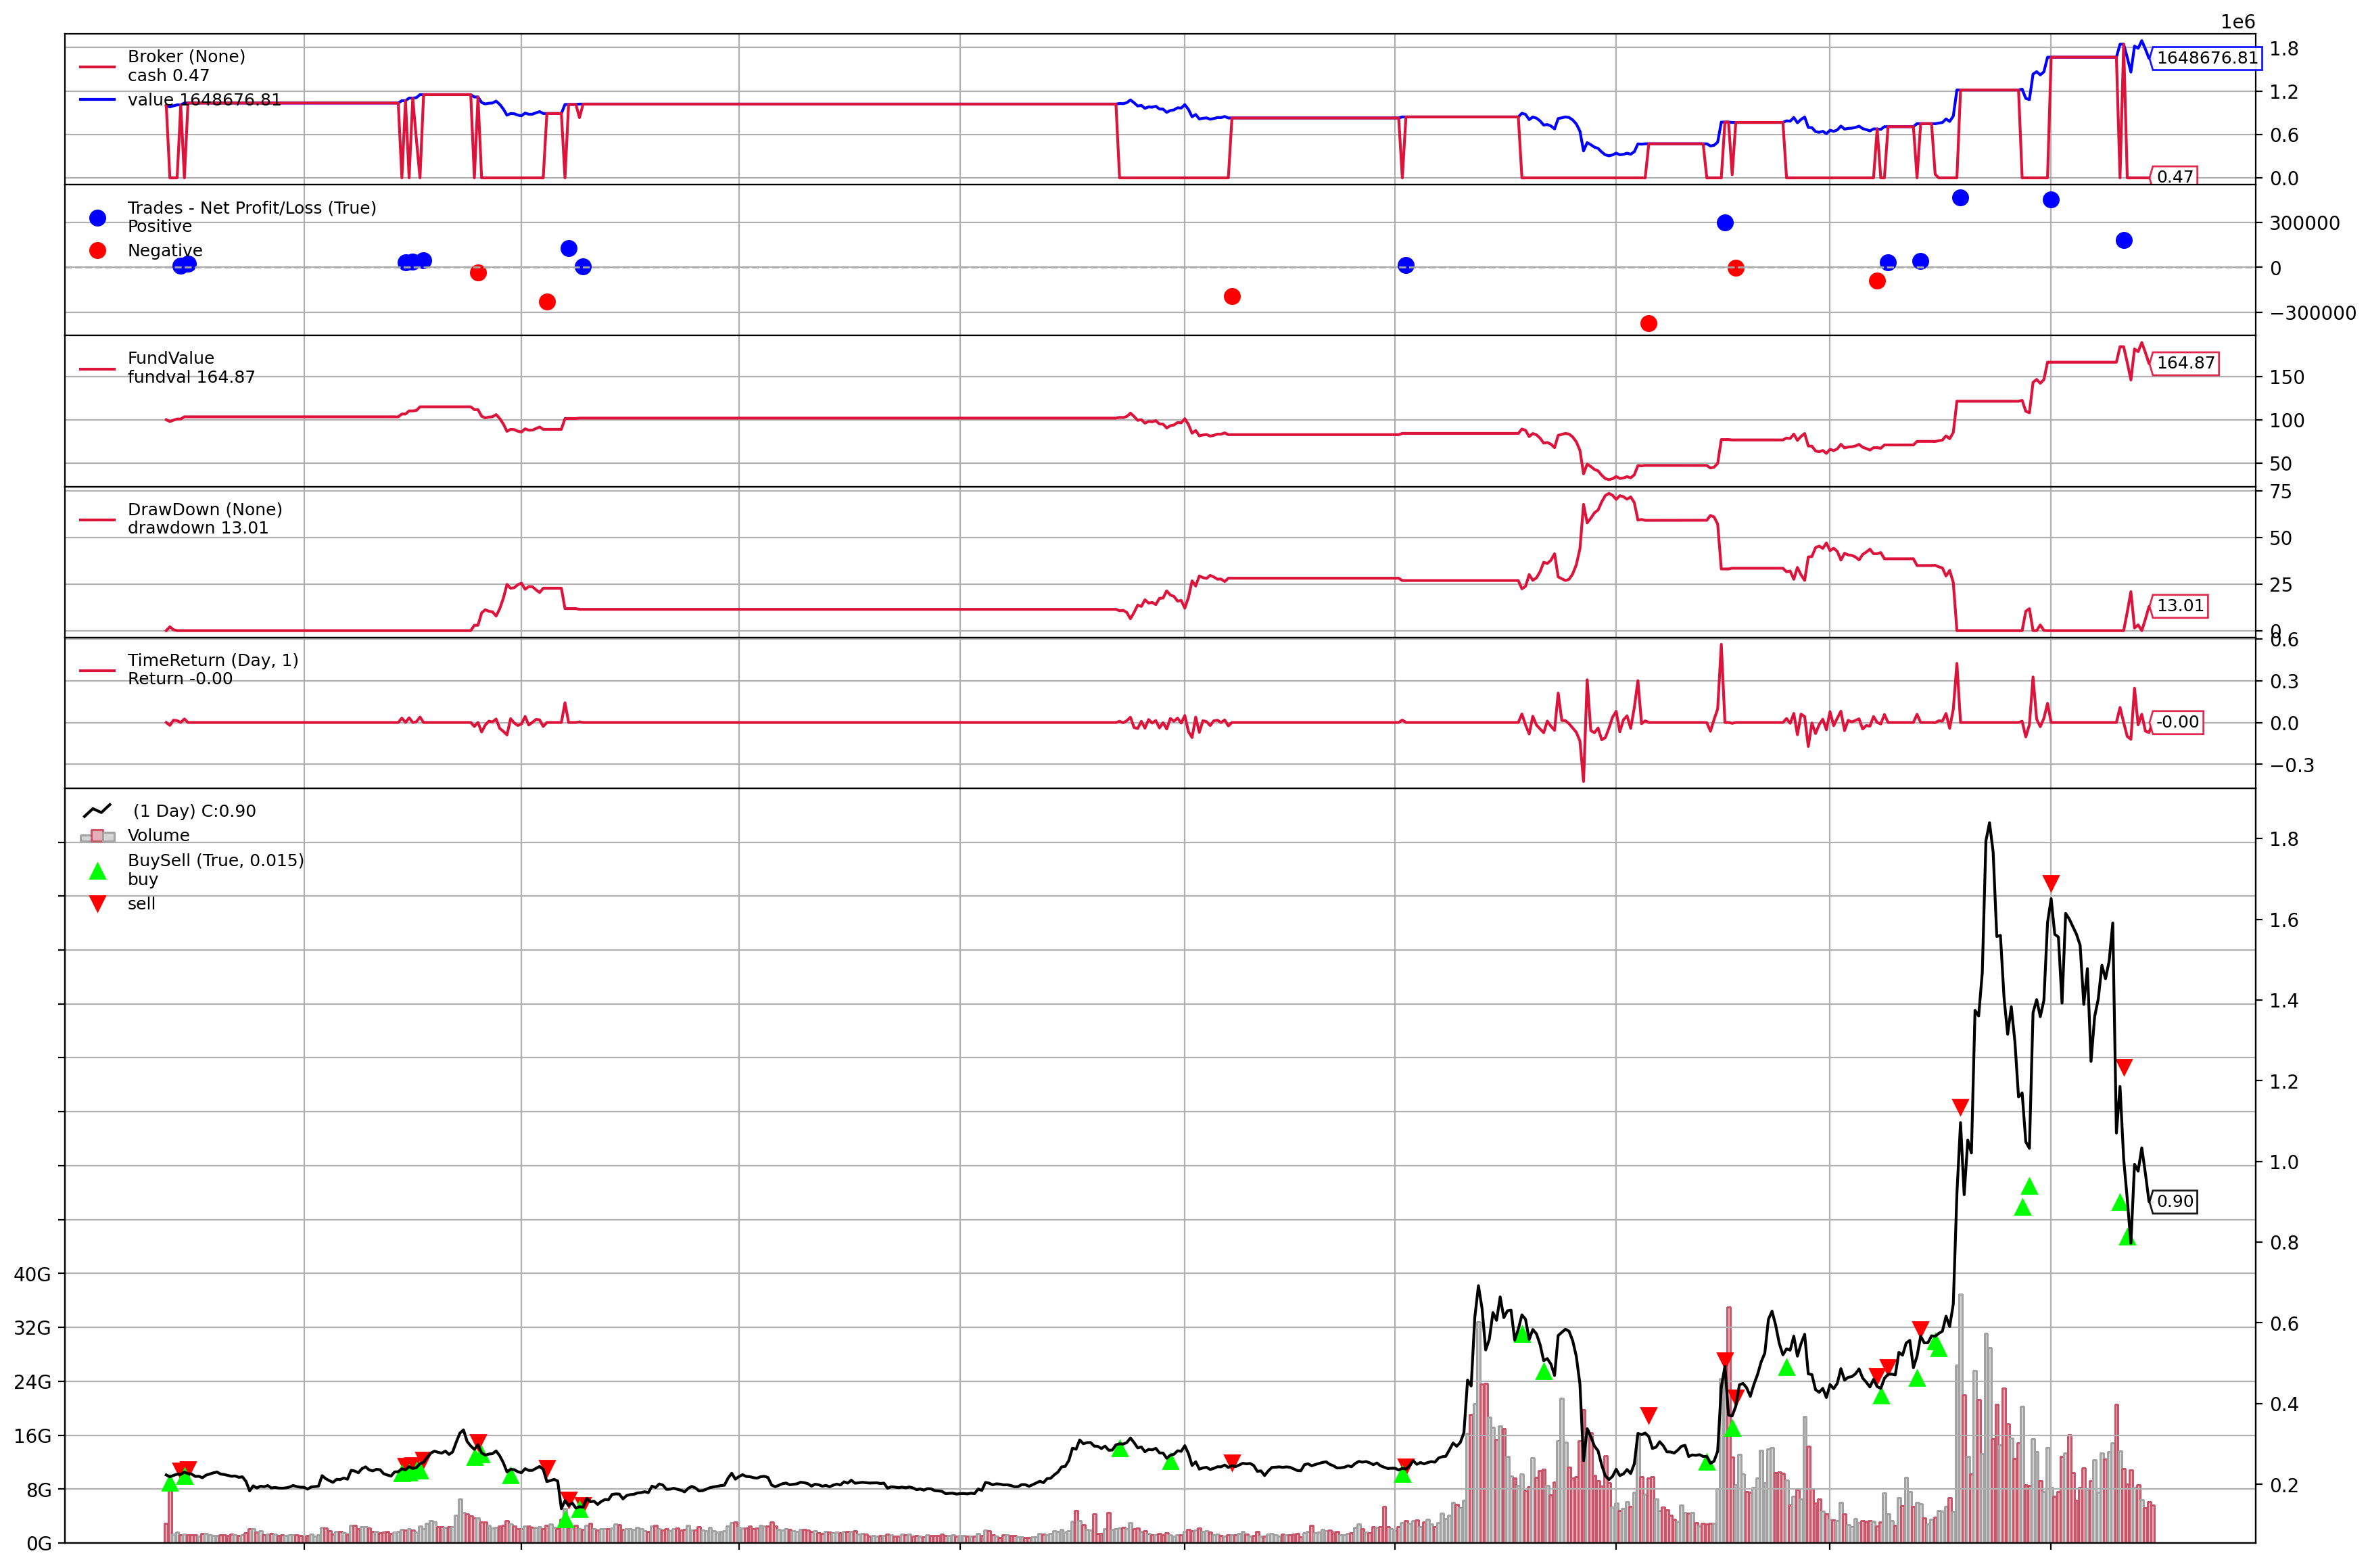

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2019, 11, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - LTC

In [ ]:
ltc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD.csv', index_col=0, parse_dates=True)
ltc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ltc_data) - len(prediction_data)
train_len

1274

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=ltc_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.04319932064155916
2019-11-24T00:00:00, 
Current f :  1
Current value:  1000000.0
2019-11-25T00:00:00, BUY EXECUTED, Price: 44.73, Cost: 999988.89, Comm 0.00
2019-11-25T00:00:00, 
Current f :  1
Current value:  1024502.487648
2019-11-26T00:00:00, 
Current f :  1
Current value:  1056759.3990640002
2019-11-27T00:00:00, 
Current f :  1
Current value:  1073199.9166120002
2019-11-28T00:00:00, 
Current f :  1
Current value:  1051922.1722960002
2019-11-29T00:00:00, 
Current f :  1
Current value:  1092655.809928
2019-11-30T00:00:00, 
Current f :  1
Current value:  1061276.874216
2019-12-01T00:00:00, 
Current f :  1
Current value:  1066546.606176
2019-12-02T00:00:00, 
Current f :  1
Current value:  1024204.7100140001
2019-12-03T00:00:00, 
Current f :  1
Current value:  1014471.4654580002
2019-12-04T00:00:00, 
Current f :  1
Current value:  1010254.33865
2019-12-05T00:00:00, 
Current f :  1
Current value:  1012683.972556
2019-12-06T00:00:00, 
Current f :  

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2019-11-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - BCH

In [ ]:
bch_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BCH-USD.csv', index_col=0, parse_dates=True)
bch_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BCH-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(bch_data) - len(prediction_data)
train_len

980

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=bch_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.058577657019125
2020-03-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2020-03-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2020-03-31T00:00:00, 
Current f :  1
Current value:  1000000.0
2020-04-01T00:00:00, BUY EXECUTED, Price: 219.63, Cost: 999964.44, Comm 0.00
2020-04-01T00:00:00, 
Current f :  1
Current value:  1020002.949868
2020-04-02T00:00:00, 
Current f :  1
Current value:  1059303.699176
2020-04-03T00:00:00, 
Current f :  1
Current value:  1073693.696985
2020-04-04T00:00:00, 
Current f :  1
Current value:  1087380.0013259999
2020-04-05T00:00:00, 
Current f :  0
Current value:  1056322.394776
2020-04-06T00:00:00, SELL EXECUTED, Price: 232.00, Cost: 999964.44, Comm 0.00
2020-04-06T00:00:00, 
Current f :  0
Current value:  1056322.394776
2020-04-07T00:00:00, 
Current f :  0
Current value:  1056322.394776
2020-04-08T00:00:00, 
Current f :  0
Current value:  1056322.394776
2020-04-09T00:00:00, 
Current f :  0
Current value:

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-3-29',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - ADA

In [ ]:
ada_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD.csv', index_col=0, parse_dates=True)
ada_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ada_data) - len(prediction_data)
train_len

931

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=ada_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.05377737775127861
2020-04-20T00:00:00, 
Current f :  1
Current value:  1000000.0
2020-04-21T00:00:00, BUY EXECUTED, Price: 0.03, Cost: 999999.98, Comm 0.00
2020-04-21T00:00:00, 
Current f :  1
Current value:  1015302.6886890001
2020-04-22T00:00:00, 
Current f :  1
Current value:  1069695.9932259996
2020-04-23T00:00:00, 
Current f :  1
Current value:  1188079.699604
2020-04-24T00:00:00, 
Current f :  1
Current value:  1225034.3761129999
2020-04-25T00:00:00, 
Current f :  1
Current value:  1240834.475333
2020-04-26T00:00:00, 
Current f :  0
Current value:  1342394.0019860002
2020-04-27T00:00:00, SELL EXECUTED, Price: 0.05, Cost: 999999.98, Comm 0.00
2020-04-27T00:00:00, 
Current f :  0
Current value:  1342394.0019860002
2020-04-28T00:00:00, 
Current f :  0
Current value:  1342394.0019860002
2020-04-29T00:00:00, 
Current f :  0
Current value:  1342394.0019860002
2020-04-30T00:00:00, 
Current f :  0
Current value:  1342394.0019860002
2020-05-01T00:0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-4-20',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## USD - BNB

In [ ]:
bnb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BNB-USD.csv', index_col=0, parse_dates=True)
bnb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BNB-USD_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(bnb_data) - len(prediction_data)
train_len

979

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=bnb_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.056291574545831155
2020-03-30T00:00:00, 
Current f :  1
Current value:  1000000.0
2020-03-31T00:00:00, BUY EXECUTED, Price: 12.29, Cost: 999989.29, Comm 0.00
2020-03-31T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-01T00:00:00, SELL EXECUTED, Price: 12.58, Cost: 999989.29, Comm 0.00
2020-04-01T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-02T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-03T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-04T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-05T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-06T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-07T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-08T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-09T00:00:00, 
Current f :  0
Current value:  1023989.876281
2020-04-10T00:00:00, 
Current f :  0
Current

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2020-3-30',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_d

Skip


# Stocks (S&P 500 big cap)

## AAPL


In [ ]:
aapl_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/AAPL.csv', index_col=0, parse_dates=True)
aapl_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/AAPL_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(aapl_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=aapl_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.011877298837140634
2018-05-10T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-11T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-14T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-15T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-22T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## FB


In [ ]:
fb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/FB.csv', index_col=0, parse_dates=True)
fb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/FB_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(fb_data) - len(prediction_data)
train_len

1584

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=fb_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.015360506477807512
2018-09-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-09-06T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-09-07T00:00:00, BUY EXECUTED, Price: 162.53, Cost: 999884.55, Comm 0.00
2018-09-07T00:00:00, 
Current f :  1
Current value:  1003137.4830879999
2018-09-10T00:00:00, 
Current f :  0
Current value:  1010150.763088
2018-09-11T00:00:00, SELL EXECUTED, Price: 164.18, Cost: 999884.55, Comm 0.00
2018-09-11T00:00:00, 
Current f :  0
Current value:  1010150.763088
2018-09-12T00:00:00, 
Current f :  1
Current value:  1010150.763088
2018-09-13T00:00:00, BUY EXECUTED, Price: 162.00, Cost: 1010070.00, Comm 0.00
2018-09-13T00:00:00, 
Current f :  1
Current value:  1006160.3693230001
2018-09-14T00:00:00, 
Current f :  1
Current value:  1012146.006733
2018-09-17T00:00:00, 
Current f :  1
Current value:  1001297.075558
2018-09-18T00:00:00, 
Current f :  1
Current value:  999551.2817930001
2018-09-19T00:00:00, 
Curr

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-9-5',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## TSLA


In [ ]:
tsla_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/TSLA.csv', index_col=0, parse_dates=True)
tsla_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/TSLA_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(tsla_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=tsla_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.022505136547682617
2018-05-18T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-05-21T00:00:00, BUY EXECUTED, Price: 55.36, Cost: 999984.53, Comm 0.00
2018-05-21T00:00:00, 
Current f :  0
Current value:  1027707.126062
2018-05-22T00:00:00, SELL EXECUTED, Price: 56.90, Cost: 999984.53, Comm 0.00
2018-05-22T00:00:00, 
Current f :  1
Current value:  1027707.126062
2018-05-23T00:00:00, BUY EXECUTED, Price: 55.00, Cost: 1027657.35, Comm 0.00
2018-05-23T00:00:00, 
Current f :  0
Current value:  1042878.5340620001
2018-05-24T00:00:00, SELL EXECUTED, Price: 55.81, Cost: 1027657.35, Comm 0.00
2018-05-24T00:00:00, 
Current f :  1
Current value:  1042878.5340620001
2018-05-25T00:00:00, BUY EXECUTED, Price: 55.57, Cost: 1042826.62, Comm 0.00
2018-05-25T00:00:00, 
Current f :  [0.30815484]
Current value:  1046631.7340620002
2018-05-29T00:00:00, SELL EXECUTED, Price: 55.77, Cost: 721409.74, Comm 0.00
2018-05-29T00:00:00, 
Current f :  0
Current value: 

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## GOOGL


In [ ]:
googl_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/GOOGL.csv', index_col=0, parse_dates=True)
googl_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/GOOGL_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(googl_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=googl_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.010507554101529615
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-22T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-07T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-08T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## BRK-B


In [ ]:
brkb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BRK-B.csv', index_col=0, parse_dates=True)
brkb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BRK-B_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(brkb_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=brkb_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.008089454231385048
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-22T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-05-30T00:00:00, BUY EXECUTED, Price: 189.87, Cost: 999855.39, Comm 0.00
2018-05-30T00:00:00, 
Current f :  0
Current value:  1022275.2379260001
2018-05-31T00:00:00, SELL EXECUTED, Price: 194.10, Cost: 999855.39, Comm 0.00
2018-05-31T00:00:00, 
Current f :  1
Current value:  1022275.2379260001
2018-06-01T00:00:00, BUY EXECUTED, Price: 191.53, Cost: 1022195.60, Comm 0.00
2018-06-01T00:00:00, 
Current f :  0
Current value:  1026011.1219150001
2018-06-04T00:00:00, SELL EXECUTED, Price: 192.23,

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## JPM


In [ ]:
jpm_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JPM.csv', index_col=0, parse_dates=True)
jpm_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JPM_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(jpm_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=jpm_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.011424641016415877
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-05-22T00:00:00, BUY EXECUTED, Price: 112.15, Cost: 999929.42, Comm 0.00
2018-05-22T00:00:00, 
Current f :  0
Current value:  1007667.76
2018-05-23T00:00:00, SELL EXECUTED, Price: 113.01, Cost: 999929.42, Comm 0.00
2018-05-23T00:00:00, 
Current f :  0
Current value:  1007667.76
2018-05-24T00:00:00, 
Current f :  0
Current value:  1007667.76
2018-05-25T00:00:00, 
Current f :  1
Current value:  1007667.76
2018-05-29T00:00:00, BUY EXECUTED, Price: 110.66, Cost: 1007559.34, Comm 0.00
2018-05-29T00:00:00, 
Current f :  1
Current value:  964601.0735800001
2018-05-30T00:00:00, BUY EXECUTED, Price: 105.93, Cost: 105.93, Comm 0.00
2018-05-30T00:00:00, 
Current f :  1
Current value:  986637.575368
2018-05-31T00:00:00, 
Current f :  1
Current value:  974435.571792
2018-06-01T00:00:00, 
Current f :  1
Current v

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## JNJ


In [ ]:
jnj_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JNJ.csv', index_col=0, parse_dates=True)
jnj_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JNJ_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(jnj_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=jnj_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.006799291978245195
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-22T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-06-04T00:00:00, BUY EXECUTED, Price: 121.26, Cost: 999909.98, Comm 0.00
2018-06-04T00:00:00, 
Current f :  0
Current value:  1005689.6987699999
2018-06-05T00:00:00, SELL EXECUTED, Price: 121.95, Cost: 999909.98, Comm 0.00
2018-06-05T00:00:00, 
Current f :  0
Current value:  1005689.69877
2018-06-06T00:00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


##SPY

In [ ]:
spy_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/SPY.csv', index_col=0, parse_dates=True)
spy_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/SPY_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(spy_data) - len(prediction_data)
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=spy_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.006178456100834046
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-22T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-07T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-08T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions, 
      transactions=transactions,
      live_start_date='2018-5-10',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


#Stocks (HSI )

## 0700 (Tencent)

In [ ]:
tencent_data = pd.read_csv(r'/content/drive/My Drive/CFE/0700.HK.csv', index_col=0, parse_dates=True)
tencent_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0700_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(tencent_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = tencent_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.01334525078469283
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  100000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2016-05-20',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 1398 (ICBC)

In [ ]:
icbc_data = pd.read_csv(r'/content/drive/My Drive/CFE/1398.HK.csv', index_col=0, parse_dates=True)
icbc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/1398_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(icbc_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = icbc_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.011575253597613544
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 4333 (CISCO-T)

In [ ]:
cisco_data = pd.read_csv(r'/content/drive/My Drive/CFE/4333.HK.csv', index_col=0, parse_dates=True)
cisco_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/4333_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(cisco_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = cisco_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
1.038888888888889
2018-05-16T00:00:00, 
Current f :  [0.03743316]
Current value:  1000000.0
2018-05-17T00:00:00, BUY EXECUTED, Price: 215.00, Cost: 37410.00, Comm 0.00
2018-05-17T00:00:00, 
Current f :  [0.03743316]
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  [0.03743316]
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-23T00:00:00, SELL EXECUTED, Price: 270.00, Cost: 7310.00, Comm 0.00
2018-05-23T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-24T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-25T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-28T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-29T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-30T00:00:00, 
Current f :  [0.03743316]
Current value:  1009570.0
2018-05-31T00:00:00, 
Current f :  [0.03743316]
Cur

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 3968 (CM Bank)

In [ ]:
cm_data = pd.read_csv(r'/content/drive/My Drive/CFE/3968.HK.csv', index_col=0, parse_dates=True)
cm_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/3968_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(cm_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = cm_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.014463037921136814
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 939 (CCB)

In [ ]:
ccb_data = pd.read_csv(r'/content/drive/My Drive/CFE/0939.HK.csv', index_col=0, parse_dates=True)
ccb_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0939_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ccb_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ccb_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.011868831825779297
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 2318 (Ping An)

In [ ]:
pingan_data = pd.read_csv(r'/content/drive/My Drive/CFE/2318.HK.csv', index_col=0, parse_dates=True)
pingan_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/2318_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(pingan_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = pingan_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.01380701616198018
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  100000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 1288 (ABC)

In [ ]:
abc_data = pd.read_csv(r'/content/drive/My Drive/CFE/1288.HK.csv', index_col=0, parse_dates=True)
abc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/1288_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(abc_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = abc_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.011542062554301616
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 1299 (AIA)

In [ ]:
aia_data = pd.read_csv(r'/content/drive/My Drive/CFE/1299.HK.csv', index_col=0, parse_dates=True)
aia_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/1299_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(aia_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = aia_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.010402348931389102
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


##0857 (Petrochina)

In [ ]:
petrochina_data = pd.read_csv(r'/content/drive/My Drive/CFE/0857.HK.csv', index_col=0, parse_dates=True)
petrochina_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/0857_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(petrochina_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = petrochina_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.012695141625583885
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 3988 (Bank of China)

In [ ]:
boc_data = pd.read_csv(r'/content/drive/My Drive/CFE/3988.HK.csv', index_col=0, parse_dates=True)
boc_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/3988_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(boc_data) - len(prediction_data)

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = boc_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.01115111483063156
2018-05-16T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-17T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-18T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-21T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-23T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-24T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-25T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-28T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-29T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-30T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-05-31T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-01T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-04T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-05T00:00:00, 
Current f :  0
Current value:  1000000.0
2018-06-06T00:00:00, 
Current f :  0
Current value:  100000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


# SSE

## 601628 (China Life Insurance)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601628.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601628_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.01639784552661321
2018-07-02T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-03T00:00:00, BUY EXECUTED, Price: 21.52, Cost: 999991.36, Comm 0.00
2018-07-03T00:00:00, 
Current f :  1
Current value:  1028345.4335319999
2018-07-04T00:00:00, 
Current f :  1
Current value:  1026486.76
2018-07-05T00:00:00, 
Current f :  1
Current value:  1041821.2000000001
2018-07-06T00:00:00, 
Current f :  1
Current value:  1049256.08
2018-07-09T00:00:00, 
Current f :  1
Current value:  1061802.44
2018-07-10T00:00:00, 
Current f :  1
Current value:  1056690.96
2018-07-11T00:00:00, 
Current f :  1
Current value:  1029739.52
2018-07-12T00:00:00, 
Current f :  1
Current value:  1057155.6400000001
2018-07-13T00:00:00, 
Current f :  1
Current value:  1055296.873532
2018-07-16T00:00:00, 
Current f :  0
Current value:  1053902.88
2018-07-17T00:00:00, SELL EXECUTED, Price: 22.68, Cost: 999991.36, Comm 0.00
2018-07-17T00:00:00, 
Current f :  0
Current value:  1053

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-02',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 601857 (Petrochina)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601857.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601857_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.01026826040968802
2018-07-02T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-03T00:00:00, BUY EXECUTED, Price: 7.51, Cost: 999994.05, Comm 0.00
2018-07-03T00:00:00, 
Current f :  1
Current value:  1002663.1000000001
2018-07-04T00:00:00, 
Current f :  1
Current value:  997336.9000000001
2018-07-05T00:00:00, 
Current f :  1
Current value:  989347.6
2018-07-06T00:00:00, 
Current f :  1
Current value:  992010.7000000001
2018-07-09T00:00:00, 
Current f :  1
Current value:  1013315.5000000001
2018-07-10T00:00:00, 
Current f :  0
Current value:  1033288.75
2018-07-11T00:00:00, SELL EXECUTED, Price: 7.76, Cost: 999994.05, Comm 0.00
2018-07-11T00:00:00, 
Current f :  0
Current value:  1033288.75
2018-07-12T00:00:00, 
Current f :  0
Current value:  1033288.75
2018-07-13T00:00:00, 
Current f :  1
Current value:  1033288.75
2018-07-16T00:00:00, BUY EXECUTED, Price: 7.60, Cost: 1033288.40, Comm 0.00
2018-07-16T00:00:00, 
Current f :  1
Current va

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-02',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 601318 (Ping An Insurance)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601318.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601318_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.014872574657532008
2018-07-02T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-03T00:00:00, BUY EXECUTED, Price: 55.22, Cost: 999979.00, Comm 0.00
2018-07-03T00:00:00, 
Current f :  1
Current value:  1020282.061891
2018-07-04T00:00:00, 
Current f :  1
Current value:  1005432.681891
2018-07-05T00:00:00, 
Current f :  1
Current value:  1005613.7537819999
2018-07-06T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-09T00:00:00, SELL EXECUTED, Price: 56.94, Cost: 999979.00, Comm 0.00
2018-07-09T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-10T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-11T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-12T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-13T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-16T00:00:00, 
Current f :  0
Current value:  1031147.443782
2018-07-17T00:00:00, 
Current f :  0
Cur

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-02',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 601939 (China Construction Bank)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601939.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601939_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.011789568786210574
2018-07-02T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-03T00:00:00, BUY EXECUTED, Price: 6.22, Cost: 999995.62, Comm 0.00
2018-07-03T00:00:00, 
Current f :  1
Current value:  1016077.1000000001
2018-07-04T00:00:00, 
Current f :  1
Current value:  1016077.1000000001
2018-07-05T00:00:00, 
Current f :  1
Current value:  1030546.49
2018-07-06T00:00:00, 
Current f :  1
Current value:  1038585.04
2018-07-09T00:00:00, 
Current f :  1
Current value:  1094854.8900000001
2018-07-10T00:00:00, 
Current f :  0
Current value:  1088424.0499999998
2018-07-11T00:00:00, SELL EXECUTED, Price: 6.77, Cost: 999995.62, Comm 0.00
2018-07-11T00:00:00, 
Current f :  1
Current value:  1088424.0499999998
2018-07-12T00:00:00, BUY EXECUTED, Price: 6.73, Cost: 1088422.71, Comm 0.00
2018-07-12T00:00:00, 
Current f :  0
Current value:  1127238.5299999998
2018-07-13T00:00:00, SELL EXECUTED, Price: 6.97, Cost: 1088422.71, Comm 0.00
2018-07-13T00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-02',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 600036 (China Merchants Bank)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600036.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600036_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.013826970164128082
2018-07-02T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-03T00:00:00, BUY EXECUTED, Price: 25.44, Cost: 999995.56, Comm 0.00
2018-07-03T00:00:00, 
Current f :  1
Current value:  991352.1613839997
2018-07-04T00:00:00, 
Current f :  1
Current value:  984669.8013839999
2018-07-05T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-06T00:00:00, 
Current f :  1
Current value:  1015723.1606919998
2018-07-09T00:00:00, 
Current f :  1
Current value:  1059355.0799999998
2018-07-10T00:00:00, 
Current f :  0
Current value:  1053458.8013839999
2018-07-11T00:00:00, SELL EXECUTED, Price: 26.80, Cost: 999995.56, Comm 0.00
2018-07-11T00:00:00, 
Current f :  1
Current value:  1053458.8013839999
2018-07-12T00:00:00, BUY EXECUTED, Price: 26.60, Cost: 1053439.80, Comm 0.00
2018-07-12T00:00:00, 
Current f :  1
Current value:  1031281.1609869999
2018-07-13T00:00:00, 
Current f :  1
Current value:  1038805.6913839999
2018-07-16

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-02',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 601398 (Industrial and Commercial Bank of China)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601398.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601398_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.010525436955987075
2018-07-02T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-07-03T00:00:00, BUY EXECUTED, Price: 5.08, Cost: 999998.00, Comm 0.00
2018-07-03T00:00:00, 
Current f :  1
Current value:  1011810.9999999999
2018-07-04T00:00:00, 
Current f :  1
Current value:  1015748.0
2018-07-05T00:00:00, 
Current f :  1
Current value:  1029527.5000000001
2018-07-06T00:00:00, 
Current f :  1
Current value:  1041338.5
2018-07-09T00:00:00, 
Current f :  0
Current value:  1088582.5
2018-07-10T00:00:00, SELL EXECUTED, Price: 5.53, Cost: 999998.00, Comm 0.00
2018-07-10T00:00:00, 
Current f :  0
Current value:  1088582.5
2018-07-11T00:00:00, 
Current f :  0
Current value:  1088582.5
2018-07-12T00:00:00, 
Current f :  0
Current value:  1088582.5
2018-07-13T00:00:00, 
Current f :  0
Current value:  1088582.5
2018-07-16T00:00:00, 
Current f :  1
Current value:  1088582.5
2018-07-17T00:00:00, BUY EXECUTED, Price: 5.23, Cost: 1088577.43, Comm 0.00
20

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-07-02',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## 600519 (Kweichow Moutai)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600519.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600519_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(ss_raw_data) - len(prediction_data)
train_len

1701

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.014651199543055363
2018-03-28T00:00:00, 
Current f :  1
Current value:  1000000.0
2018-03-29T00:00:00, BUY EXECUTED, Price: 682.05, Cost: 999885.28, Comm 0.00
2018-03-29T00:00:00, 
Current f :  0
Current value:  1010335.282408
2018-03-30T00:00:00, SELL EXECUTED, Price: 689.10, Cost: 999885.28, Comm 0.00
2018-03-30T00:00:00, 
Current f :  0
Current value:  1010335.282408
2018-04-02T00:00:00, 
Current f :  1
Current value:  1010335.282408
2018-04-03T00:00:00, BUY EXECUTED, Price: 680.06, Cost: 1009889.10, Comm 0.00
2018-04-03T00:00:00, 
Current f :  1
Current value:  1007142.4952829999
2018-04-04T00:00:00, 
Current f :  0
Current value:  1031051.0502279998
2018-04-09T00:00:00, SELL EXECUTED, Price: 694.01, Cost: 1009889.10, Comm 0.00
2018-04-09T00:00:00, 
Current f :  1
Current value:  1031051.0502279998
2018-04-10T00:00:00, BUY EXECUTED, Price: 698.30, Cost: 1030690.78, Comm 0.00
2018-04-10T00:00:00, 
Current f :  1
Current value:  1045397.817459

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-03-20',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


#Phase 2


## 2 week data


### Parse the raw_data


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/lstm_stock_predictions/crypto_2_weeks.csv', index_col=0, parse_dates=True)
crypto_data = {}
for name in raw_data.index.unique() :
  print(name)
  crypto_data[name] = pd.DataFrame()
  crypto_data[name]['Time'] = pd.to_datetime(raw_data.loc[name]['TIME'], format='%d-%m-%y %H:%M:%S')
  crypto_data[name]['Close'] = (raw_data.loc[name]['ASK'] + raw_data.loc[name]['BID'])/2
  crypto_data[name] = crypto_data[name].set_index('Time')
  crypto_data[name] = crypto_data[name].sort_index()


YFI/USD
UNI/USD
LINK/USD
ADA/USD
DOT/USD
DOG/USD
UST/USD
LTC/USD
ETH/USD
BTC/USD


###YFI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/YFI-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['YFI/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['YFI/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current f :  0
Current value:  892341.5
2021-06-13T03:00:21, SELL EXECUTED, Price: 36498.50, Cost: 875916.00, Comm 0.00
2021-06-13T03:00:21, 
Current f :  1
Current value:  892341.5
2021-06-13T03:00:31, BUY EXECUTED, Price: 36484.50, Cost: 875628.00, Comm 0.00
2021-06-13T03:00:31, 
Current f :  0
Current value:  892305.5
2021-06-13T03:00:41, SELL EXECUTED, Price: 36483.00, Cost: 875628.00, Comm 0.00
2021-06-13T03:00:41, 
Current f :  1
Current value:  892305.5
2021-06-13T03:00:51, BUY EXECUTED, Price: 36451.50, Cost: 874836.00, Comm 0.00
2021-06-13T03:00:51, 
Current f :  0
Current value:  892293.5
2021-06-13T03:01:01, SELL EXECUTED, Price: 36451.00, Cost: 874836.00, Comm 0.00
2021-06-13T03:01:01, 
Current f :  1
Current value:  892293.5
2021-06-13T03:01:11, BUY EXECUTED, Price: 36438.50, Cost: 874524.00, Comm 0.00
2021-06-13T03:01:11, 
Current f :  0
Current value:  892281.5
2021-06-13T03:01:21, SELL EXECUTED, Price: 36438.00, Cost: 8

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


### UNI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UNI-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UNI/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UNI/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  943739.2274999984
2021-06-13T02:42:31, 
Current f :  1
Current value:  943607.8994999983
2021-06-13T02:42:41, 
Current f :  1
Current value:  943498.4594999985
2021-06-13T02:42:51, 
Current f :  1
Current value:  943476.5714999983
2021-06-13T02:43:01, 
Current f :  1
Current value:  943651.6754999983
2021-06-13T02:43:11, 
Current f :  1
Current value:  943739.2274999984
2021-06-13T02:43:21, 
Current f :  1
Current value:  944023.7714999983
2021-06-13T02:43:31, 
Current f :  1
Current value:  943826.7794999984
2021-06-13T02:43:41, 
Current f :  1
Current value:  943651.6754999984
2021-06-13T02:43:51, 
Current f :  1
Current value:  943673.5634999984
2021-06-13T02:44:01, 
Current f :  1
Current value:  943695.4514999983
2021-06-13T02:44:11, 
Current f :  1
Current value:  943695.4514999983
2021-06-13T02:44:21, 
Current f :  1
Current value:  943695.4514999983
2021-06-13T02:44:31, 
Current f :  1
Current value:  943498.459

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###LINK-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LINK-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LINK/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LINK/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  975213.5369999998
2021-06-13T02:42:31, 
Current f :  1
Current value:  974878.6469999998
2021-06-13T02:42:41, 
Current f :  1
Current value:  974744.6909999999
2021-06-13T02:42:51, 
Current f :  1
Current value:  974744.6909999999
2021-06-13T02:43:01, 
Current f :  1
Current value:  974610.7349999999
2021-06-13T02:43:11, 
Current f :  1
Current value:  974588.4089999998
2021-06-13T02:43:21, 
Current f :  1
Current value:  974521.4309999997
2021-06-13T02:43:31, 
Current f :  1
Current value:  974566.0829999996
2021-06-13T02:43:41, 
Current f :  1
Current value:  974633.0609999996
2021-06-13T02:43:51, 
Current f :  1
Current value:  974700.0389999998
2021-06-13T02:44:01, 
Current f :  1
Current value:  974700.0389999998
2021-06-13T02:44:11, 
Current f :  1
Current value:  974677.7129999998
2021-06-13T02:44:21, 
Current f :  1
Current value:  974588.4089999998
2021-06-13T02:44:31, 
Current f :  1
Current value:  974633.060

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###ADA-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ADA/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ADA/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  998365.9864499999
2021-06-13T02:42:51, 
Current f :  1
Current value:  998365.9864499999
2021-06-13T02:43:01, 
Current f :  1
Current value:  998467.2097499999
2021-06-13T02:43:11, 
Current f :  1
Current value:  998467.2097499999
2021-06-13T02:43:21, 
Current f :  1
Current value:  998365.9864499999
2021-06-13T02:43:31, 
Current f :  1
Current value:  998365.9864499999
2021-06-13T02:43:41, 
Current f :  1
Current value:  997320.0123499999
2021-06-13T02:43:51, 
Current f :  1
Current value:  997927.3521499999
2021-06-13T02:44:01, 
Current f :  1
Current value:  997792.3877499999
2021-06-13T02:44:11, 
Current f :  1
Current value:  997353.75345
2021-06-13T02:44:21, 
Current f :  1
Current value:  997353.75345
2021-06-13T02:44:31, 
Current f :  1
Current value:  997286.27125
2021-06-13T02:44:41, 
Current f :  1
Current value:  997320.0123499999
2021-06-13T02:44:51, 
Current f :  1
Current value:  997252.53015
2021-06-13T0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


###DOT-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOT-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOT/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOT/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current f :  1
Current value:  907390.8160000012
2021-06-13T02:43:41, 
Current f :  1
Current value:  907303.952000001
2021-06-13T02:43:51, 
Current f :  1
Current value:  907412.5320000009
2021-06-13T02:44:01, 
Current f :  1
Current value:  907390.8160000012
2021-06-13T02:44:11, 
Current f :  1
Current value:  907369.100000001
2021-06-13T02:44:21, 
Current f :  1
Current value:  907369.100000001
2021-06-13T02:44:31, 
Current f :  1
Current value:  907325.668000001
2021-06-13T02:44:41, 
Current f :  1
Current value:  907369.100000001
2021-06-13T02:44:51, 
Current f :  1
Current value:  907282.2360000011
2021-06-13T02:45:01, 
Current f :  1
Current value:  907347.3840000011
2021-06-13T02:45:11, 
Current f :  1
Current value:  907151.9400000009
2021-06-13T02:45:21, 
Current f :  1
Current value:  907499.396000001
2021-06-13T02:45:31, 
Current f :  1
Current value:  907564.544000001
2021-06-13T02:45:41, 
Current f :  1
Current value:  90

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


###DOG-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOG-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOG/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOG/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current f :  1
Current value:  3319205.0
2021-06-13T02:58:21, 
Current f :  1
Current value:  3316255.0
2021-06-13T02:58:30, 
Current f :  1
Current value:  3318205.0
2021-06-13T02:58:41, 
Current f :  1
Current value:  3315305.0
2021-06-13T02:58:51, 
Current f :  0
Current value:  3319405.0
2021-06-13T02:59:01, SELL EXECUTED, Price: 311760.00, Cost: 3114900.00, Comm 0.00
2021-06-13T02:59:01, 
Current f :  0
Current value:  3319405.0
2021-06-13T02:59:10, 
Current f :  1
Current value:  3319405.0
2021-06-13T02:59:21, BUY EXECUTED, Price: 311315.00, Cost: 3113150.00, Comm 0.00
2021-06-13T02:59:21, 
Current f :  1
Current value:  3318905.0
2021-06-13T02:59:31, 
Current f :  1
Current value:  3319205.0
2021-06-13T02:59:41, 
Current f :  1
Current value:  3321755.0
2021-06-13T02:59:51, 
Current f :  1
Current value:  3320105.0
2021-06-13T03:00:01, 
Current f :  0
Current value:  3322155.0
2021-06-13T03:00:11, SELL EXECUTED, Price: 311590.00

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###UST-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UST-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UST/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UST/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
2021-06-13T03:07:20, 
Current f :  1
Current value:  1001951.1310650009
2021-06-13T03:07:30, 
Current f :  0
Current value:  1001951.1310650009
2021-06-13T03:07:40, SELL EXECUTED, Price: 1.00, Cost: 1001950.42, Comm 0.00
2021-06-13T03:07:40, 
Current f :  0
Current value:  1001951.1310650009
2021-06-13T03:07:50, 
Current f :  1
Current value:  1001951.1310650009
2021-06-13T03:08:00, BUY EXECUTED, Price: 1.00, Cost: 1001950.42, Comm 0.00
2021-06-13T03:08:00, 
Current f :  1
Current value:  1001951.1310650009
2021-06-13T03:08:10, 
Current f :  1
Current value:  1001951.1310650009
2021-06-13T03:08:20, 
Current f :  1
Current value:  1001951.1310650009
2021-06-13T03:08:30, 
Current f :  0
Current value:  1001951.1310650009
2021-06-13T03:08:40, SELL EXECUTED, Price: 1.00, Cost: 1001950.42, Comm 0.00
2021-06-13T03:08:40, 
Current f :  0
Current value:  1001951.1310650009
2021-06-13T03:08:50, 
Current f :  1
Current value:  1001951.1310650009

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###LTC-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LTC/USD']) - len(prediction_data)
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LTC/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current f :  1
Current value:  939490.1749999983
2021-06-13T02:49:20, 
Current f :  1
Current value:  939839.9749999983
2021-06-13T02:49:30, 
Current f :  1
Current value:  939694.2249999985
2021-06-13T02:49:40, 
Current f :  1
Current value:  939665.0749999983
2021-06-13T02:49:50, 
Current f :  0
Current value:  939810.8249999983
2021-06-13T02:50:00, SELL EXECUTED, Price: 161.19, Cost: 940320.70, Comm 0.00
2021-06-13T02:50:00, 
Current f :  0
Current value:  939810.8249999983
2021-06-13T02:50:10, 
Current f :  1
Current value:  939810.8249999983
2021-06-13T02:50:20, BUY EXECUTED, Price: 161.12, Cost: 939783.80, Comm 0.00
2021-06-13T02:50:20, 
Current f :  0
Current value:  939839.9899999984
2021-06-13T02:50:30, SELL EXECUTED, Price: 161.12, Cost: 939783.80, Comm 0.00
2021-06-13T02:50:30, 
Current f :  1
Current value:  939839.9899999982
2021-06-13T02:50:40, BUY EXECUTED, Price: 161.13, Cost: 939739.32, Comm 0.00
2021-06-13T02:50:40, 


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


### ETH-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ETH/USD']) - len(prediction_data)
train_len 

62713

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ETH/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.00047737227487403586
2021-06-13T05:18:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:18:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:21:00, 
Current f :  0
Current value:  100

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


###BTC-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_2_Week_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['BTC/USD']) - len(prediction_data)
train_len

62713

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['BTC/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.000388014387542392
2021-06-13T05:18:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:18:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:19:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:20:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T05:21:00, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


## 1 month data


### Parse the raw_data


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/lstm_stock_predictions/crypto_1_month.csv', index_col=0, parse_dates=True)
crypto_data = {}
for name in raw_data.index.unique() :
  print(name)
  crypto_data[name] = pd.DataFrame()
  crypto_data[name]['Time'] = pd.to_datetime(raw_data.loc[name]['TIME'], format='%d-%m-%y %H:%M:%S')
  crypto_data[name]['Close'] = (raw_data.loc[name]['ASK'] + raw_data.loc[name]['BID'])/2
  crypto_data[name] = crypto_data[name].set_index('Time')
  crypto_data[name] = crypto_data[name].sort_index()


UST/USD
BTC/USD
ETH/USD
LTC/BTC
YFI/USD
UNI/USD
LINK/USD
ADA/USD
DOT/USD
DOG/USD


###YFI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/YFI-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['YFI/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['YFI/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  945291.0
2021-06-13T07:34:41, 
Current f :  1
Current value:  945317.0
2021-06-13T07:34:51, 
Current f :  1
Current value:  945265.0
2021-06-13T07:35:01, 
Current f :  1
Current value:  945265.0
2021-06-13T07:35:11, 
Current f :  1
Current value:  944589.0
2021-06-13T07:35:21, 
Current f :  1
Current value:  944433.0
2021-06-13T07:35:31, 
Current f :  1
Current value:  944394.0
2021-06-13T07:35:41, 
Current f :  1
Current value:  943900.0
2021-06-13T07:35:51, 
Current f :  1
Current value:  943796.0
2021-06-13T07:36:01, 
Current f :  1
Current value:  943731.0
2021-06-13T07:36:11, 
Current f :  1
Current value:  943705.0
2021-06-13T07:36:21, 
Current f :  1
Current value:  943523.0
2021-06-13T07:36:31, 
Current f :  1
Current value:  943601.0
2021-06-13T07:36:41, 
Current f :  1
Current value:  943809.0
2021-06-13T07:36:51, 
Current f :  1
Current value:  943796.0
2021-06-13T07:37:01, 
Current f :  1
Current value:  943

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


### UNI-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UNI-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UNI/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UNI/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
2021-06-13T07:35:31, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:35:41, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:35:51, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:36:01, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:36:11, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:36:21, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:36:31, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:36:41, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:36:51, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:37:01, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:37:11, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:37:21, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07:37:31, 
Current f :  0
Current value:  1005417.4170000025
2021-06-13T07

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:298: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  'ons from transactions. Set estimate_intraday' +


###LINK-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LINK-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LINK/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LINK/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  915503.9014999988
2021-06-13T07:34:41, 
Current f :  1
Current value:  915460.0274999986
2021-06-13T07:34:51, 
Current f :  1
Current value:  916052.3264999986
2021-06-13T07:35:01, 
Current f :  1
Current value:  915416.1534999986
2021-06-13T07:35:11, 
Current f :  1
Current value:  914845.7914999987
2021-06-13T07:35:21, 
Current f :  1
Current value:  914823.8544999986
2021-06-13T07:35:31, 
Current f :  1
Current value:  914165.7444999986
2021-06-13T07:35:41, 
Current f :  1
Current value:  913683.1304999986
2021-06-13T07:35:51, 
Current f :  1
Current value:  913397.9494999987
2021-06-13T07:36:01, 
Current f :  1
Current value:  913156.6424999988
2021-06-13T07:36:11, 
Current f :  1
Current value:  913880.5634999987
2021-06-13T07:36:21, 
Current f :  1
Current value:  913748.9414999988
2021-06-13T07:36:31, 
Current f :  1
Current value:  913705.0674999986
2021-06-13T07:36:41, 
Current f :  1
Current value:  914099.933

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###ADA-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ADA/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ADA/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
2021-06-13T07:34:51, 
Current f :  1
Current value:  956231.5812999958
2021-06-13T07:35:01, 
Current f :  1
Current value:  955701.5564999956
2021-06-13T07:35:11, 
Current f :  1
Current value:  955171.5316999957
2021-06-13T07:35:21, 
Current f :  1
Current value:  955204.6582499957
2021-06-13T07:35:31, 
Current f :  1
Current value:  955270.9113499958
2021-06-13T07:35:41, 
Current f :  1
Current value:  955039.0254999957
2021-06-13T07:35:51, 
Current f :  1
Current value:  955039.0254999957
2021-06-13T07:36:01, 
Current f :  1
Current value:  954509.0006999958
2021-06-13T07:36:11, 
Current f :  1
Current value:  954906.5192999957
2021-06-13T07:36:21, 
Current f :  1
Current value:  954972.7723999957
2021-06-13T07:36:31, 
Current f :  1
Current value:  954740.8865499957
2021-06-13T07:36:41, 
Current f :  1
Current value:  954873.3927499958
2021-06-13T07:36:51, 
Current f :  1
Current value:  954939.6458499957
2021-06-13T07:37:01, 
Curr

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###DOT-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOT-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOT/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOT/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  968049.9359999985
2021-06-13T07:34:41, 
Current f :  1
Current value:  967598.7714999986
2021-06-13T07:34:51, 
Current f :  1
Current value:  967598.7714999986
2021-06-13T07:35:01, 
Current f :  1
Current value:  967670.0079999986
2021-06-13T07:35:11, 
Current f :  1
Current value:  966625.2059999986
2021-06-13T07:35:21, 
Current f :  1
Current value:  966530.2239999986
2021-06-13T07:35:31, 
Current f :  1
Current value:  965651.6404999987
2021-06-13T07:35:41, 
Current f :  1
Current value:  965058.0029999986
2021-06-13T07:35:51, 
Current f :  1
Current value:  965081.7484999985
2021-06-13T07:36:01, 
Current f :  1
Current value:  965271.7124999987
2021-06-13T07:36:11, 
Current f :  1
Current value:  965271.7124999987
2021-06-13T07:36:21, 
Current f :  1
Current value:  965200.4759999985
2021-06-13T07:36:31, 
Current f :  1
Current value:  965295.4579999985
2021-06-13T07:36:41, 
Current f :  1
Current value:  965295.457

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


###DOG-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOG-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['DOG/USD']) - len(prediction_data)
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOG/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  1691770.0
2021-06-13T08:04:01, 
Current f :  1
Current value:  1691770.0
2021-06-13T08:04:11, BUY EXECUTED, Price: 308910.00, Cost: 1544550.00, Comm 0.00
2021-06-13T08:04:11, 
Current f :  0
Current value:  1691245.0
2021-06-13T08:04:21, SELL EXECUTED, Price: 308805.00, Cost: 1544550.00, Comm 0.00
2021-06-13T08:04:21, 
Current f :  0
Current value:  1691245.0
2021-06-13T08:04:30, 
Current f :  0
Current value:  1691245.0
2021-06-13T08:04:41, 
Current f :  1
Current value:  1691245.0
2021-06-13T08:04:50, BUY EXECUTED, Price: 309070.00, Cost: 1545350.00, Comm 0.00
2021-06-13T08:04:50, 
Current f :  0
Current value:  1691020.0
2021-06-13T08:05:01, SELL EXECUTED, Price: 309025.00, Cost: 1545350.00, Comm 0.00
2021-06-13T08:05:01, 
Current f :  0
Current value:  1691020.0
2021-06-13T08:05:11, 
Current f :  1
Current value:  1691020.0
2021-06-13T08:05:21, BUY EXECUTED, Price: 309290.00, Cost: 1546450.00, Comm 0.00
2021-06-13T0

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###UST-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/UST-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['UST/USD']) - len(prediction_data)
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UST/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
2021-06-13T07:39:40, 
Current f :  0
Current value:  1001645.8967800041
2021-06-13T07:39:50, SELL EXECUTED, Price: 1.00, Cost: 1001645.45, Comm 0.00
2021-06-13T07:39:50, 
Current f :  1
Current value:  1001645.8967800041
2021-06-13T07:40:00, BUY EXECUTED, Price: 1.00, Cost: 1001645.45, Comm 0.00
2021-06-13T07:40:00, 
Current f :  0
Current value:  1001645.8967800041
2021-06-13T07:40:10, SELL EXECUTED, Price: 1.00, Cost: 1001645.45, Comm 0.00
2021-06-13T07:40:10, 
Current f :  1
Current value:  1001645.8967800041
2021-06-13T07:40:20, BUY EXECUTED, Price: 1.00, Cost: 1001645.45, Comm 0.00
2021-06-13T07:40:20, 
Current f :  0
Current value:  1001645.8967800041
2021-06-13T07:40:30, SELL EXECUTED, Price: 1.00, Cost: 1001645.45, Comm 0.00
2021-06-13T07:40:30, 
Current f :  1
Current value:  1001645.8967800041
2021-06-13T07:40:41, BUY EXECUTED, Price: 1.00, Cost: 1001645.45, Comm 0.00
2021-06-13T07:40:41, 
Current f :  0
Current value:  10016

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###LTC-BTC

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-BTC_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['LTC/BTC']) - len(prediction_data)
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LTC/BTC'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Streaming output truncated to the last 5000 lines.
Current value:  970584.7613099505
2021-06-13T07:34:50, 
Current f :  1
Current value:  970498.4141939505
2021-06-13T07:35:00, 
Current f :  1
Current value:  970422.8604674503
2021-06-13T07:35:10, 
Current f :  1
Current value:  970498.4141939505
2021-06-13T07:35:20, 
Current f :  1
Current value:  970433.6538569505
2021-06-13T07:35:30, 
Current f :  1
Current value:  970142.2323404503
2021-06-13T07:35:40, 
Current f :  1
Current value:  970120.6455614505
2021-06-13T07:35:50, 
Current f :  1
Current value:  969796.8438764503
2021-06-13T07:36:00, 
Current f :  1
Current value:  969710.4967604504
2021-06-13T07:36:10, 
Current f :  1
Current value:  969807.6372659504
2021-06-13T07:36:20, 
Current f :  1
Current value:  969710.4967604504
2021-06-13T07:36:30, 
Current f :  1
Current value:  969516.2157494503
2021-06-13T07:36:40, 
Current f :  1
Current value:  969321.9347384506
2021-06-13T07:36:50, 
Current f :  1
Current value:  969181.620

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### ETH-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['ETH/USD']) - len(prediction_data)
train_len 

65273

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ETH/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.0006283362560569282
2021-06-13T10:11:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:13:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:13:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:13:20, 
Current f :  0
Current value:  1000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip


###BTC-USD

In [ ]:
prediction_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD_1_Month_Predicted.csv', index_col=0, parse_dates=True)
prediction_data['Close'] = prediction_data['Predicted']
train_len = len(crypto_data['BTC/USD']) - len(prediction_data)
train_len

65273

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(Lstm_Discrete_Strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['BTC/USD'])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
0
0.000501704667291534
2021-06-13T10:11:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:11:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:20, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:30, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:40, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:12:50, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:13:00, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:13:10, 
Current f :  0
Current value:  1000000.0
2021-06-13T10:13:20, 
Current f :  0
Current value:  10000

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2021-06-13',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/pyfolio/utils.py:266: RuntimeWarning: invalid value encountered in long_scalars
  return daily_pos.count(axis=1).sum() / txn_count < threshold
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/p

Skip
